# Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Change directory to where this file is located
"""
%cd /content/drive/MyDrive/study/Github/MLDL1/Lab/Lab3

/content/drive/MyDrive/study/Github/MLDL1/Lab/Lab3


In [ ]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 5.6 MB/s 
     |████████████████████████████████| 138 kB 43.0 MB/s 
     |████████████████████████████████| 127 kB 56.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchtext
from torch.utils.data import Dataset, DataLoader

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))
print("Using torchtext version: {}".format(torchtext.__version__))

Using PyTorch version: 1.11.0+cu113, Device: cuda
Using torchtext version: 0.12.0


# Utils

In [ ]:
def train(model, train_loader, optimizer, scheduler = None):
    model.train()
    train_loss = 0
    correct = 0
    tqdm_bar = tqdm(enumerate(train_loader))
    for batch_idx, (image, label) in tqdm_bar:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        optimizer.step()
        tqdm_bar.set_description("Epoch {} - train loss: {:.6f}".format(epoch, loss.item()))
    if scheduler is not None:
        scheduler.step()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    return train_loss, train_acc

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in tqdm(test_loader):
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
def plot_history(history):
    plt.figure(figsize=(3 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_loss'], label="train_loss")
    plt.plot(history['test_loss'], label="test_loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Training and Validation Accuracy")
    plt.plot(history['train_acc'], label="train_acc")
    plt.plot(history['test_acc'], label="test_acc")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 5, 3)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

In [ ]:
def plot_dataset(dataloader, grid_width=8, grid_height=2, figure_width=12, figure_height=3, y_hats=None):
    images, labels = next(iter(dataloader))
    f, ax = plt.subplots(grid_height, grid_width)
    f.set_size_inches(figure_width, figure_height)
    img_idx = 0
    for i in range(0, grid_height):
        for j in range(0, grid_width):
            image = images[img_idx]
            label = labels[img_idx]
            title_color = 'k'
            if y_hats is None:
                label_idx = int(label)
            else:
                label_idx = int(y_hats[img_idx])
                if int(labels[img_idx]) != label_idx:
                    title_color = 'r'
            label = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'][label_idx]
            ax[i][j].axis('off')
            ax[i][j].set_title(label, color=title_color)
            image = image.squeeze(axis=0)
            ax[i][j].imshow(image, cmap=plt.get_cmap('gray'))
            img_idx += 1
        plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    plt.show()

# Load Fashion MNIST

In [ ]:
BATCH_SIZE = 1024
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data/', train=True, download=True,
                          transform=transforms.Compose([transforms.ToTensor(),
                                                        transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data/', train=False, transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                          ])),
                          batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



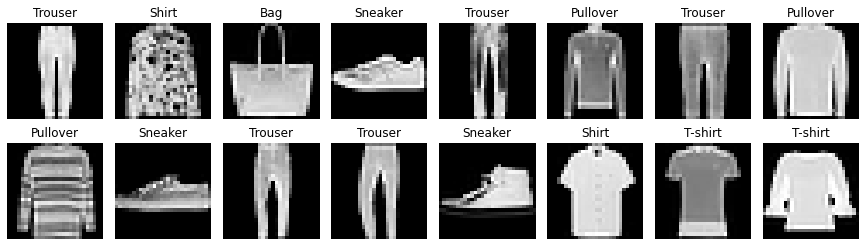

In [ ]:
plot_dataset(train_loader)

# Custom Dropout

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("dropout probability has to be between 0 and 1, "
                             "but got {}".format(p))
        self.p = p

    def forward(self, input):
        #### TODO ####
        # drop-out 에 의해 값들이 유실되었으므로 다음 층에서 input 값들의 영향력을 보존해주기 위해 self.p로 나눔
        # node 수가 100, 1000 커질수록 self.p 비율과 거의 비슷해짐
        mask = (np.random.rand(*input.shape) < self.p) / self.p 
        output = input * torch.Tensor(mask).to(DEVICE) # don't forget when customization model
        ##############
        return output.to(DEVICE)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + str(self.p) + ')'

In [ ]:
x = torch.rand((3,2))
x

tensor([[0.2192, 0.3153],
        [0.5478, 0.4510],
        [0.2792, 0.3071]])

In [ ]:
Dropout()(x)

tensor([[0.0000, 0.6305],
        [0.0000, 0.9020],
        [0.5584, 0.0000]])

In [ ]:
# What happens if dropout ratio is too low (= no dropout)?

class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)  
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0010, 	Train Loss: 0.0008, 	Train Accuracy: 70.29 %, 	Test Loss: 0.0005, 	Test Accuracy: 81.36 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 83.87 %, 	Test Loss: 0.0004, 	Test Accuracy: 84.47 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.0010, 	Train Loss: 0.0004, 	Train Accuracy: 85.87 %, 	Test Loss: 0.0004, 	Test Accuracy: 85.58 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 87.01 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.66 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 87.84 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.74 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 88.35 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.60 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 88.91 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.35 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 89.40 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.44 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 89.87 %, 	Test Loss: 0.0003, 	Test Accuracy: 87.97 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 90.20 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.18 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 11], 	LR: 0.0010, 	Train Loss: 0.0003, 	Train Accuracy: 90.35 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.09 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 12], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 90.85 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.39 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 13], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 90.96 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.55 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 14], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 91.47 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.91 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 15], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.03 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.59 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 16], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.10 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.38 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 17], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.17 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.88 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 18], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.73 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.06 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 19], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.44 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.61 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 20], 	LR: 0.0010, 	Train Loss: 0.0002, 	Train Accuracy: 92.84 %, 	Test Loss: 0.0003, 	Test Accuracy: 89.07 % 



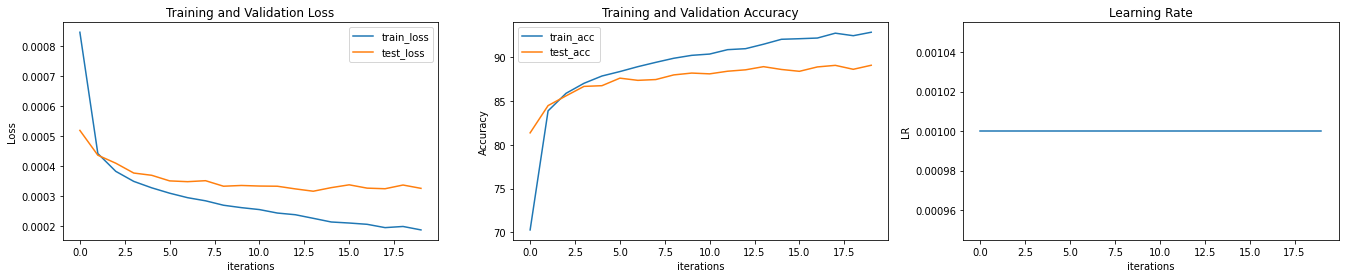

In [ ]:
EPOCHS = 20
model = SimpleClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
plot_history(history)

In [ ]:
class RegClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        self.dropout = Dropout(p=0.3)
    
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x),dim=1)
        
        return x

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0010, 	Train Loss: 0.0017, 	Train Accuracy: 33.93 %, 	Test Loss: 0.0013, 	Test Accuracy: 53.56 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0010, 	Train Loss: 0.0010, 	Train Accuracy: 61.21 %, 	Test Loss: 0.0009, 	Test Accuracy: 66.02 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.0010, 	Train Loss: 0.0008, 	Train Accuracy: 68.24 %, 	Test Loss: 0.0008, 	Test Accuracy: 69.53 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.0010, 	Train Loss: 0.0008, 	Train Accuracy: 70.58 %, 	Test Loss: 0.0008, 	Test Accuracy: 71.16 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.0010, 	Train Loss: 0.0007, 	Train Accuracy: 72.31 %, 	Test Loss: 0.0007, 	Test Accuracy: 72.56 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.0010, 	Train Loss: 0.0007, 	Train Accuracy: 74.04 %, 	Test Loss: 0.0007, 	Test Accuracy: 73.84 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.0010, 	Train Loss: 0.0007, 	Train Accuracy: 75.22 %, 	Test Loss: 0.0007, 	Test Accuracy: 74.87 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.0010, 	Train Loss: 0.0007, 	Train Accuracy: 76.02 %, 	Test Loss: 0.0007, 	Test Accuracy: 75.15 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 76.90 %, 	Test Loss: 0.0007, 	Test Accuracy: 75.79 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 10], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 77.39 %, 	Test Loss: 0.0007, 	Test Accuracy: 76.68 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 11], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 78.09 %, 	Test Loss: 0.0007, 	Test Accuracy: 76.57 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 12], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 78.60 %, 	Test Loss: 0.0007, 	Test Accuracy: 78.27 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 13], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 79.31 %, 	Test Loss: 0.0006, 	Test Accuracy: 78.36 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 14], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 79.81 %, 	Test Loss: 0.0006, 	Test Accuracy: 78.86 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 15], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 79.83 %, 	Test Loss: 0.0006, 	Test Accuracy: 78.76 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 16], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 80.42 %, 	Test Loss: 0.0006, 	Test Accuracy: 79.33 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 17], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 80.54 %, 	Test Loss: 0.0006, 	Test Accuracy: 79.27 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 18], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 80.71 %, 	Test Loss: 0.0006, 	Test Accuracy: 79.01 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 19], 	LR: 0.0010, 	Train Loss: 0.0006, 	Train Accuracy: 80.97 %, 	Test Loss: 0.0006, 	Test Accuracy: 80.07 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 20], 	LR: 0.0010, 	Train Loss: 0.0005, 	Train Accuracy: 81.32 %, 	Test Loss: 0.0006, 	Test Accuracy: 79.89 % 



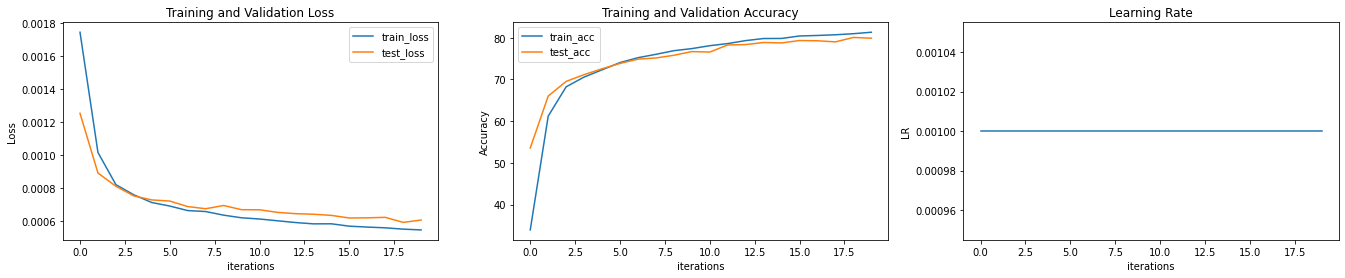

In [ ]:
EPOCHS = 20
model = RegClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
plot_history(history)

In [ ]:
# What happens if dropout ratio is too high?

class RegClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,10)
        self.dropout = Dropout(p=0.7)
    
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x),dim=1)
        
        return x

In [ ]:
EPOCHS = 20
model = RegClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
plot_history(history)

# Add regularization to the model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.Dropout(p=0.3), # pre-implemented drop-out
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 10),
        )
    
    def forward(self,x):
        x = self.conv(x)
        return x

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.0009, 	Train Loss: 0.0009, 	Train Accuracy: 69.84 %, 	Test Loss: 0.0005, 	Test Accuracy: 82.82 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.0008, 	Train Loss: 0.0004, 	Train Accuracy: 83.83 %, 	Test Loss: 0.0004, 	Test Accuracy: 84.82 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.0007, 	Train Loss: 0.0004, 	Train Accuracy: 86.04 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.68 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 4], 	LR: 0.0007, 	Train Loss: 0.0004, 	Train Accuracy: 86.75 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.33 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 5], 	LR: 0.0006, 	Train Loss: 0.0004, 	Train Accuracy: 87.31 %, 	Test Loss: 0.0004, 	Test Accuracy: 87.51 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 6], 	LR: 0.0005, 	Train Loss: 0.0003, 	Train Accuracy: 87.78 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.06 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 7], 	LR: 0.0005, 	Train Loss: 0.0003, 	Train Accuracy: 88.32 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.51 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 8], 	LR: 0.0004, 	Train Loss: 0.0003, 	Train Accuracy: 88.47 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.24 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 9], 	LR: 0.0004, 	Train Loss: 0.0003, 	Train Accuracy: 88.46 %, 	Test Loss: 0.0003, 	Test Accuracy: 88.21 % 



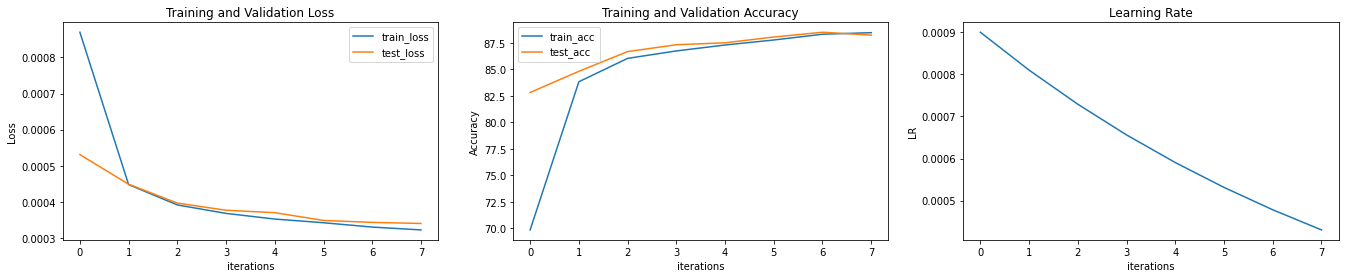

In [ ]:
## How to apply early stopping?

from torch.optim.lr_scheduler import ExponentialLR as ExponentialLR

EPOCHS = 10
#### TODO ####
best_loss = 1000
##############
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

model = Model().to(DEVICE)
# weight_decay - epoch마다 weight 값 감소시킴 
# or loss function을 customize (with lambda)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tLR: {:.4f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, optimizer.param_groups[0]['lr'], train_loss, train_accuracy, test_loss, test_accuracy))

    #### TODO ####
    if test_loss < best_loss:
      best_loss = test_loss
    else:
      break
    ##############

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
plot_history(history)

# Custom Learning Rate Scheduler

In [ ]:
## Implementing custom learning rate scheduler

class ScheduledOptim():

    def __init__(self, optimizer, n_warmup_steps, decay_rate, steps=None):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.decay = decay_rate
        self.n_steps = 0
        self.steps = steps
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.current_lr = optimizer.param_groups[0]['lr']

    def zero_grad(self):
        self._optimizer.zero_grad()

    def step(self):
        self.update()
        # self._optimizer.step()
    
    def get_lr(self):
        return self.current_lr
    
    def update(self):
        #### TODO ####
        # warm up
        if self.n_steps < self.n_warmup_steps:
          lr = self.n_steps / self.n_warmup_steps * self.initial_lr
        elif self.n_steps == self.n_warmup_steps:
          lr = self.initial_lr
        else:
          if self.steps is None:
            lr = self.current_lr * self.decay
          else:
            if self.n_steps in self.steps:
              lr = self.current_lr * self.decay
            else:
              lr = self.current_lr
        self.current_lr = lr
        for param_group in self._optimizer.param_groups:
          param_group['lr'] = lr

        ##############

        self.n_steps += 1

In [ ]:
## How to apply customized learning rate 

EPOCHS = 10
history = {'train_loss':[], 'train_acc':[], 'test_loss':[], 'test_acc':[], 'lr':[]}

model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#### TODO ####
scheduler = ScheduledOptim(optimizer, n_warmup_steps=3, decay_rate=0.5)
patience = 2
best_loss = 1000

# 안 하면 warm up 안 됨
scheduler.update()
##############

for epoch in range(1, EPOCHS + 1):
    lr = scheduler.get_lr()
    train_loss, train_accuracy = train(model, train_loader, optimizer, scheduler)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tLR: {:.5f}, \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.2f} %, \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, lr, train_loss, train_accuracy, test_loss, test_accuracy))
    
    #### TODO ####
    if test_loss < best_loss:
      best_loss = test_loss
    else:
      patience += 1
      if patience >= 2:
        break
    ##############

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_accuracy)
    history['lr'].append(lr)
    
plot_history(history)

0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 1], 	LR: 0.00000, 	Train Loss: 0.0024, 	Train Accuracy: 8.98 %, 	Test Loss: 0.0024, 	Test Accuracy: 9.81 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 2], 	LR: 0.00033, 	Train Loss: 0.0008, 	Train Accuracy: 72.79 %, 	Test Loss: 0.0005, 	Test Accuracy: 82.34 % 



0it [00:00, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


[EPOCH: 3], 	LR: 0.00067, 	Train Loss: 0.0004, 	Train Accuracy: 84.22 %, 	Test Loss: 0.0004, 	Test Accuracy: 86.62 % 



0it [00:00, ?it/s]

TypeError: ignored

# RNN Text Classification

In [ ]:
train_data, test_data = torchtext.datasets.AG_NEWS(root='./data')
labels = [_, 'World', 'Sports', 'Business', 'Sci/Tech']
y, x = next(iter(train_data))
print(labels[y])
print(x)

Business
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [ ]:
y, x = next(iter(test_data))
print(labels[y])
print(x)

Business
Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.


In [ ]:
set([label for (label, text) in train_data]), set([label for (label, text) in test_data])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/datapipes/iter/combining.py:181: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  "the buffer and each child DataPipe will read from the start again.", UserWarning)


({1, 2, 3, 4}, {1, 2, 3, 4})

In [ ]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')
tokenizer("Hi, my name is Joonseok!")

['hi', ',', 'my', 'name', 'is', 'joonseok', '!']

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

def tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

encoder = build_vocab_from_iterator(tokens(train_data), specials=["<unk>"])
encoder.set_default_index(encoder["<unk>"])

encoder(tokenizer("Hi, my name is Joonseok <unk> !"))

[24104, 3, 1300, 951, 21, 0, 0, 764]

In [ ]:
text_pipeline = lambda x: encoder(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [ ]:
iterator = iter(train_data)
sample_batch = []
for _ in range(8):
    sample_batch.append(next(iterator))

In [ ]:
## What happens if we ignore zero-padding
MAX_LEN = 32
def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.stack(text_list).long()
    return label_list, text_list

In [ ]:
collate_batch(sample_batch)

RuntimeError: ignored

In [ ]:
MAX_LEN = 32

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        if processed_text.size(0) >= MAX_LEN:
            processed_text = processed_text[:MAX_LEN]
        else:
            processed_text = torch.cat([processed_text, 
                                  torch.zeros(MAX_LEN-processed_text.size(0))])
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.stack(text_list).long()
    return label_list, text_list

In [ ]:
collate_batch(sample_batch)

In [ ]:
dataloader = DataLoader(train_data, batch_size=8, shuffle=False, collate_fn=collate_batch)

y, x = next(iter(dataloader))
x.shape, y.shape

In [ ]:
num_class = len(set([label for (label, text) in train_data]))
vocab_size = len(encoder)
emsize = 64
hidden_dim = 32

embedding = nn.Embedding(vocab_size, emsize)
rnn = nn.RNN(emsize, hidden_dim, 1, nonlinearity='tanh', bias=True, batch_first=True)
fc = nn.Linear(hidden_dim, num_class)

In [ ]:
## Check the tensor shapes after each layer

init_h = torch.randn(1, 8, hidden_dim)
output, hidden = rnn(embedding(x), init_h)
# embedding(x).shape
# fc(output).shape

In [ ]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, hidden, embed, num_class, batch_size):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed)
        self.rnn = nn.RNN(input_size=embed, hidden_size=hidden, 
                          num_layers=1, nonlinearity='tanh', 
                          bias=True, batch_first=True)
        self.fc = nn.Linear(hidden, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        x = self.embedding(x)
        x, h = self.rnn(x)
        x = torch.mean(x, dim=1)
        return self.fc(x)

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text) in enumerate(dataloader):
        label, text = label.to(DEVICE), text.to(DEVICE)
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            label, text = label.to(DEVICE), text.to(DEVICE)
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
from torchtext.data.functional import to_map_style_dataset

# Hyperparameter Setup

EPOCHS = 5
LR = 1
BATCH_SIZE = 64
num_class = len(set([label for (label, text) in train_data]))
vocab_size = len(encoder)
emsize = 64
hidden_dim = 32

model = TextClassificationModel(vocab_size, hidden_dim, emsize, num_class, BATCH_SIZE).to(DEVICE)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataset = to_map_style_dataset(train_data)
test_dataset = to_map_style_dataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

In [ ]:
## Train the RNN for text classification

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)